## Clinical Phenotyping: From Naive Clustering to PCA-Optimized K-Means

### 1. Setup & Preprocessing
We load the cleaned cohort, isolate clinical features, handle missingness with a conservative median imputation, and clip extreme values to reduce outlier distortion.

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

DATA_PATH = Path("../data/processed/01_cleaned_data.csv")
OUT_PATH = Path("../data/processed/02_clustered_data.csv")
FIG_DIR = Path("../figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

cleaned = pd.read_csv(DATA_PATH)

exclude_cols = {
    "Patient ID",
    "SARS-Cov-2 exam result",
    "Patient age quantile",
    "Patient addmited to regular ward (1=yes, 0=no)",
    "Patient addmited to semi-intensive unit (1=yes, 0=no)",
    "Patient addmited to intensive care unit (1=yes, 0=no)",
}

feature_cols = [
    c
    for c in cleaned.columns
    if c not in exclude_cols and pd.api.types.is_numeric_dtype(cleaned[c])
]

X_raw = cleaned[feature_cols].copy()

# Drop features with >90% missingness
missing_frac = X_raw.isna().mean()
feature_cols = missing_frac[missing_frac < 0.90].index.tolist()
X_raw = X_raw[feature_cols]

# Median imputation
imputer = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(imputer.fit_transform(X_raw), columns=feature_cols, index=X_raw.index)

# Outlier clipping to reduce extreme medical values
X_clipped = X_imputed.clip(lower=-4, upper=4)

### 2. Attempt 1: The Naive Approach (K-Means on Raw Data)
K-Means is sensitive to outliers and high-dimensional noise. On raw features, it tends to form one dominant blob and a few small outlier clusters.

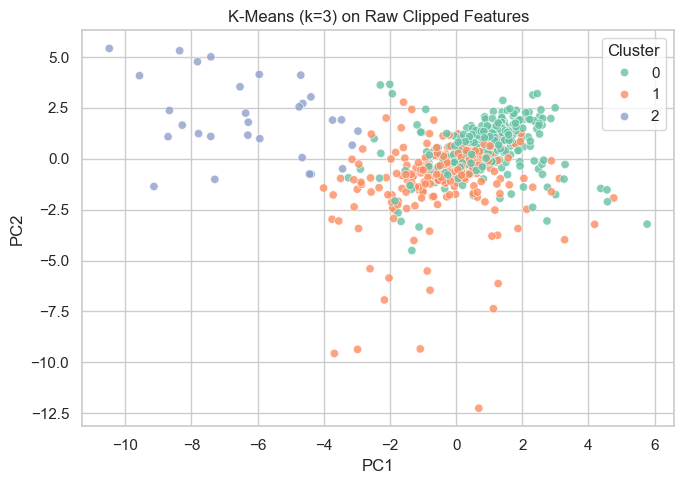

In [73]:
kmeans_raw = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_kmeans_raw = kmeans_raw.fit_predict(X_clipped)

pca_vis = PCA(n_components=2, random_state=42)
coords_kmeans_raw = pca_vis.fit_transform(X_clipped)

kmeans_raw_df = pd.DataFrame(coords_kmeans_raw, columns=["PC1", "PC2"], index=cleaned.index)
kmeans_raw_df["Cluster"] = labels_kmeans_raw.astype(str)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(7, 5))
sns.scatterplot(data=kmeans_raw_df, x="PC1", y="PC2", hue="Cluster", palette="Set2", alpha=0.8)
plt.title("K-Means (k=3) on Raw Clipped Features")
plt.tight_layout()
plt.savefig(FIG_DIR / "pca_kmeans_naive.png", dpi=300)
plt.show()

**Analysis:** The clusters are highly imbalanced, consistent with K-Means being distorted by extreme medical values and noise in high dimensions.

### 3. Attempt 2: Hierarchical Clustering (Density Approach)
Agglomerative clustering on clipped data improves global structure, but still yields one massive "normal" group and two small outlier groups.

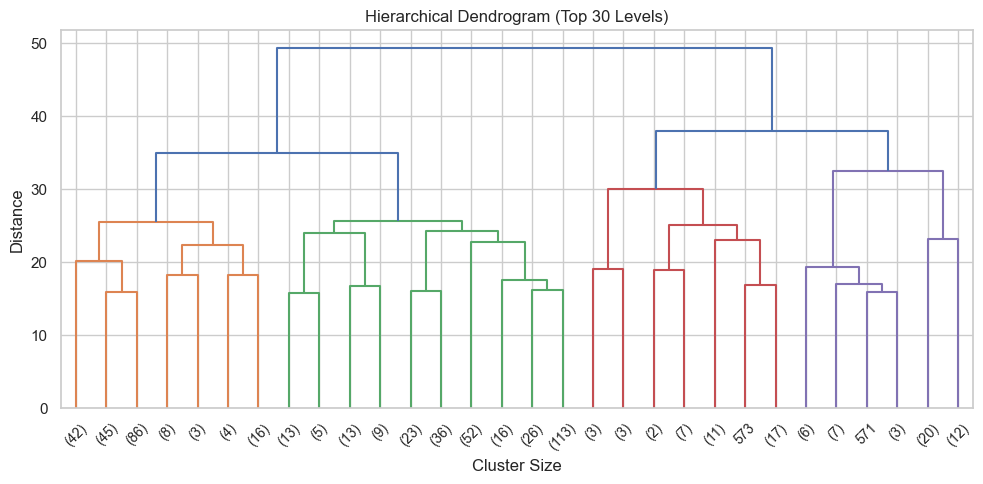

Hierarchical cluster counts:
0    510
1     49
2     44
Name: count, dtype: int64


In [74]:
linkage_matrix = linkage(X_clipped, method="ward")
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix, truncate_mode="lastp", p=30)
plt.title("Hierarchical Dendrogram (Top 30 Levels)")
plt.xlabel("Cluster Size")
plt.ylabel("Distance")
plt.tight_layout()
plt.savefig(FIG_DIR / "dendrogram_ward.png", dpi=300)
plt.show()

agg_raw = AgglomerativeClustering(n_clusters=3, linkage="ward")
labels_agg_raw = agg_raw.fit_predict(X_clipped)
print("Hierarchical cluster counts:")
print(pd.Series(labels_agg_raw).value_counts().sort_index())

**Analysis:** The dendrogram suggests structure, but cluster sizes remain heavily skewed, failing to separate mild vs. moderate patients.

### 4. Attempt 3: Optimized Solution (K-Means on PCA)
PCA removes noise while preserving 95% of variance, allowing K-Means to split the large stable cohort into clinically meaningful subgroups.

In [75]:
pca_95 = PCA(n_components=0.95, random_state=42)
X_pca = pca_95.fit_transform(X_clipped)
print(f"PCA components selected (95% variance): {X_pca.shape[1]}")

kmeans_pca = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_kmeans_pca = kmeans_pca.fit_predict(X_pca)

print("K-Means on PCA cluster counts:")
print(pd.Series(labels_kmeans_pca).value_counts().sort_index())

PCA components selected (95% variance): 26
K-Means on PCA cluster counts:
0     26
1    300
2    277
Name: count, dtype: int64


**Analysis:** PCA-based clustering yields more balanced groups, suggesting it separates stable vs. inflammatory patients while preserving a smaller severe cluster.

### 5. Final Visualization & Characterization (Attempt 3 Labels)
We interpret clusters using original clinical markers (not PCA components) to preserve clinical meaning.

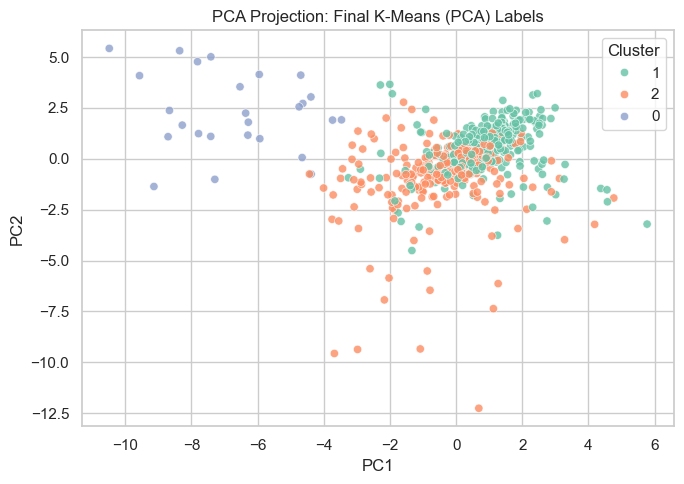

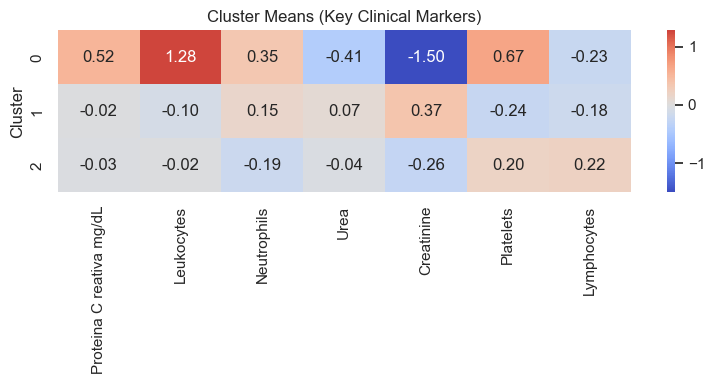

Clinical interpretation (by marker severity):
2          Stable
0    Inflammatory
1         Failure
dtype: object


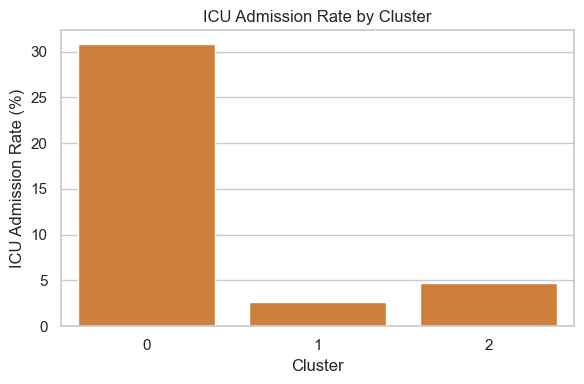

In [76]:
final_labels = labels_kmeans_pca

clustered = cleaned.copy()
clustered["Cluster"] = final_labels

pca_2 = PCA(n_components=2, random_state=42)
pca_coords = pca_2.fit_transform(X_clipped)

pca_df = pd.DataFrame(pca_coords, columns=["PC1", "PC2"], index=clustered.index)
pca_df["Cluster"] = clustered["Cluster"].astype(str)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(7, 5))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster", palette="Set2", alpha=0.8)
plt.title("PCA Projection: Final K-Means (PCA) Labels")
plt.tight_layout()
plt.savefig(FIG_DIR / "pca_clusters.png", dpi=300)
plt.show()

marker_cols = [
    "Proteina C reativa mg/dL",
    "Leukocytes",
    "Neutrophils",
    "Urea",
    "Creatinine",
    "Platelets",
    "Lymphocytes",
]

available_markers = [c for c in marker_cols if c in clustered.columns]
missing_markers = [c for c in marker_cols if c not in clustered.columns]
if missing_markers:
    print(f"Missing markers for heatmap: {missing_markers}")

centroids = clustered.groupby("Cluster")[available_markers].mean()

plt.figure(figsize=(8, 4))
sns.heatmap(centroids, cmap="coolwarm", center=0, annot=True, fmt=".2f")
plt.title("Cluster Means (Key Clinical Markers)")
plt.tight_layout()
plt.savefig(FIG_DIR / "heatmap_cluster_centroids.png", dpi=300)
plt.show()

# Interpret clusters by a composite severity score from key markers
severity_markers = [c for c in [
    "Proteina C reativa mg/dL",
    "Leukocytes",
    "Neutrophils",
    "Urea",
    "Creatinine",
] if c in centroids.columns]

severity_score = centroids[severity_markers].mean(axis=1).sort_values()
cluster_order = severity_score.index.tolist()
cluster_labels = {
    cluster_order[0]: "Stable",
    cluster_order[1]: "Inflammatory",
    cluster_order[2]: "Failure",
}

print("Clinical interpretation (by marker severity):")
print(pd.Series(cluster_labels))

icu_col = "Patient addmited to intensive care unit (1=yes, 0=no)"
if icu_col in clustered.columns:
    icu_rate = clustered.groupby("Cluster")[icu_col].mean() * 100
    plt.figure(figsize=(6, 4))
    sns.barplot(x=icu_rate.index.astype(str), y=icu_rate.values, color="#e67e22")
    plt.title("ICU Admission Rate by Cluster")
    plt.xlabel("Cluster")
    plt.ylabel("ICU Admission Rate (%)")
    plt.tight_layout()
    plt.savefig(FIG_DIR / "icu_rate_by_cluster.png", dpi=300)
    plt.show()
else:
    print(f"ICU column not found: {icu_col}")

### 6. Export
We save the final labels from the PCA-based K-Means solution for downstream analysis.

In [77]:
clustered.to_csv(OUT_PATH, index=False)
print(f"Saved clustered data to {OUT_PATH}")

Saved clustered data to ..\data\processed\02_clustered_data.csv
